# This notebook is analzying the spectral parameters from the frontal EEG channels pre and post ECT.

We are only including frontal because we are basing our analyses off of Smith, 2022, in which their dataset only uses fronto-central channels. Additionally, the treatment is targeted to frontal/central areas.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
from scipy.stats import zscore
from pingouin import ttest, normality, wilcoxon
from cliffs_delta import cliffs_delta

from ect_plotting_functions import plot_feature_prepost
from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

%matplotlib inline

/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [4]:
FRONTAL_ONLY = False

In [5]:
# load dataframe
exp_df = pd.read_csv('../saved_files_appeal/ect_files/ect_all_features.csv', index_col = 0)
# Exclude channels flagged as bad fits
exp_df_included = exp_df[exp_df['exclude']==False]

In [6]:
# frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
#                     'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
#                     'FC4', 'FC6', 'FT8', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6']
frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
                    'F2', 'F4', 'F6', 'F8', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
                    'FC4', 'FC6']


if FRONTAL_ONLY:
    exp_df_included = exp_df_included[exp_df_included['channel'].isin(frontal_channels)]
else:
    exp_df_included = exp_df_included

## Load SpecParam Fits

In [7]:
fits_pre = np.load('../saved_files_appeal/ect_files/fits_pre.npy')
fits_post = np.load('../saved_files_appeal/ect_files/fits_post.npy')
freq_axis = np.load('../saved_files_appeal/ect_files/freq_axis.npy')

**Correct for excluded fits**

In [8]:
# get boolean area with True to exclude channels from patients
to_exclude_pre = exp_df['exclude'][exp_df['pre_post']=='pre'].values
to_exclude_post = exp_df['exclude'][exp_df['pre_post']=='post'].values

# reshape fits array from [23, 60,99] --> [1390, 99]
fits_pre_flat = fits_pre.reshape(len(to_exclude_pre), fits_pre.shape[2])
fits_post_flat = fits_post.reshape(len(to_exclude_pre), fits_pre.shape[2])

# replace to excluded ones with nans
fits_pre_flat[to_exclude_pre] = np.nan
fits_post_flat[to_exclude_post] = np.nan

# reshape back to original array from  [1390, 99] --> [23, 60,99]
fits_pre_included = fits_pre_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])
fits_post_included = fits_post_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])

## Load PSD's

In [9]:
psd_pre = np.load('../saved_files_appeal/ect_files/pre_ect_psd.npy')
psd_post = np.load('../saved_files_appeal/ect_files/post_ect_psd.npy')

**Correct for excluded PSD's**

In [10]:
# reshape psd array from [23, 60,99] --> [1390, 99]
psd_pre_flat = psd_pre.reshape(len(to_exclude_pre), psd_pre.shape[2])
psd_post_flat = psd_post.reshape(len(to_exclude_pre), psd_pre.shape[2])

# replace to excluded ones with nans
psd_pre_flat[to_exclude_pre] = np.nan
psd_post_flat[to_exclude_post] = np.nan

# reshape back to original array from  [1390, 99] --> [23, 60,99]
psd_pre_included = psd_pre_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])
psd_post_included = psd_post_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])

### Replace NaN's with 0's for oscillatory amplitude (aperiodic adjusted)

There are so few delta oscillations, that we cannot run statistics (later on) using delta_amp. Therefore, we want to put a value instead of a NaN, and say that no oscillation = 0 mV. 

We may not end up using this no nan dataframe, and simply use permutation testing instead, but keeping this here just in case.

In [11]:
df_include_nonan = exp_df_included.copy()
df_include_nonan['delta_amp'] = df_include_nonan['delta_amp'].fillna(0)
df_include_nonan['theta_amp'] = df_include_nonan['theta_amp'].fillna(0)
df_include_nonan['alpha_amp'] = df_include_nonan['alpha_amp'].fillna(0)
df_include_nonan

,patient,pre_post,channel,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,error,r_squared,exclude
60,3,pre,FP1,NaN,NaN,0.000000,-12.279434,6.790739,1.708818,0.291898,-12.231911,10.421338,1.528815,0.855082,-11.788772,-12.111868,0.316378,0.040006,0.937334,False
61,3,pre,FPZ,NaN,NaN,0.000000,-12.285447,6.781832,1.721869,0.293552,-12.230147,10.432449,1.497039,0.851908,-11.789616,-12.120095,0.306056,0.039734,0.936617,False
62,3,pre,FP2,NaN,NaN,0.000000,-12.256804,6.804059,1.635148,0.222632,-12.241600,10.437381,1.510919,0.844164,-11.785411,-12.086374,0.309757,0.042277,0.924793,False
63,3,pre,AF3,NaN,NaN,0.000000,-12.084083,6.953850,1.000000,0.295863,-12.108402,8.822930,1.313243,0.696545,-11.777202,-12.058416,0.245171,0.029719,0.975417,False
64,3,pre,AF4,NaN,NaN,0.000000,-12.075505,6.840641,1.000000,0.268200,-12.063785,8.892293,1.455401,0.673468,-11.759426,-11.908936,0.323975,0.038674,0.914714,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,55,post,PO6,2.553998,1.0,0.929427,-10.025173,5.050188,2.393840,0.906087,-10.488895,8.863919,1.844095,1.337793,-10.768737,-9.895581,1.948355,0.054988,0.995060,False
2756,55,post,PO8,2.569041,1.0,0.928161,-9.978571,5.097560,2.418158,0.944726,-10.431467,8.884905,2.130652,1.246806,-10.807347,-9.840422,1.973505,0.053256,0.995397,False
2757,55,post,O1,2.552898,1.0,0.873010,-10.044384,4.996738,2.143285,0.928408,-10.464177,8.783556,2.447756,1.084474,-10.882132,-9.898193,1.863237,0.070752,0.991415,False
2758,55,post,OZ,2.523770,1.0,0.875591,-10.084470,5.088170,2.412693,0.990875,-10.494461,8.749089,1.844394,1.053670,-11.083623,-9.911188,2.021214,0.056417,0.994520,False


## Averaging Over All (*Frontal*) Electrodes Per Subject

**Average over with amplitudes as 0 (i.e. exp_df_mean_nonan)**

In [12]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_bw', 'alpha_cf']
exp_df_mean_nonan = pd.DataFrame(df_include_nonan.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

**Average over with NaNs (i.e. exp_df_mean)**

In [13]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_bw', 'alpha_cf']
exp_df_mean = pd.DataFrame(exp_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

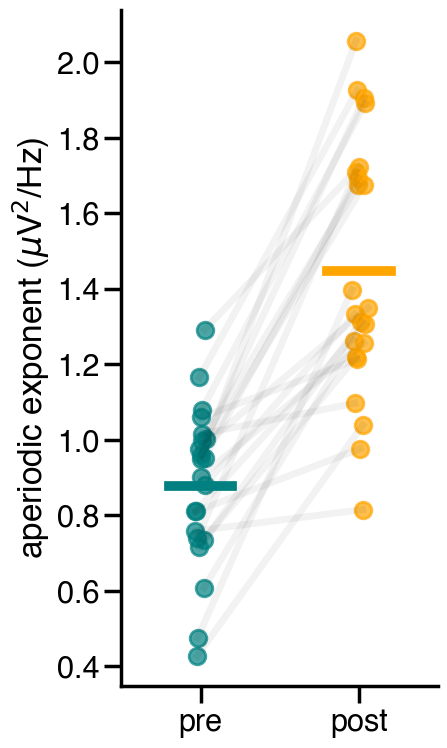

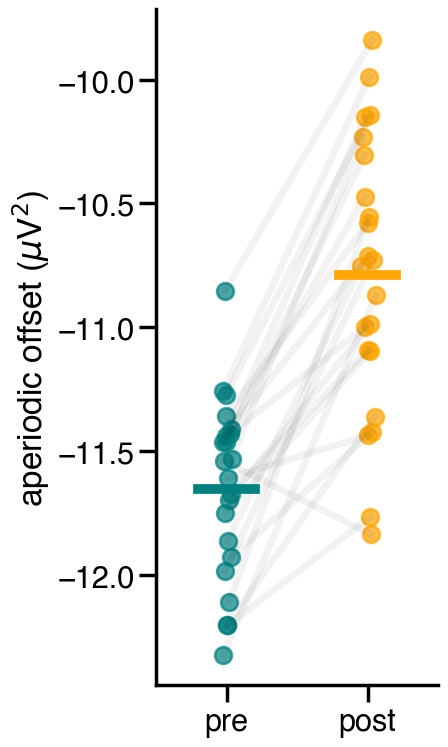

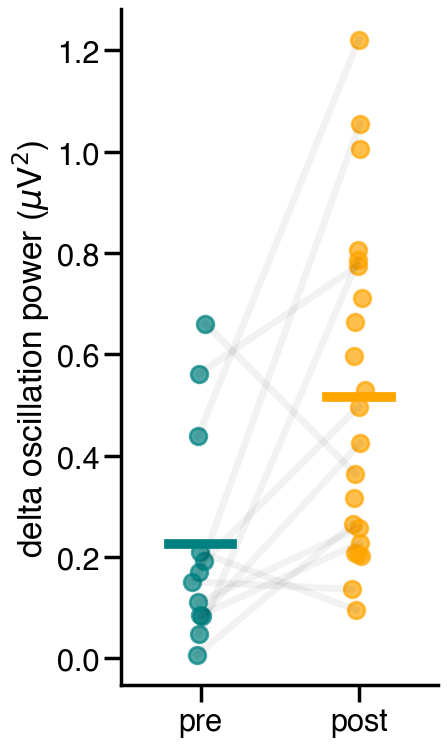

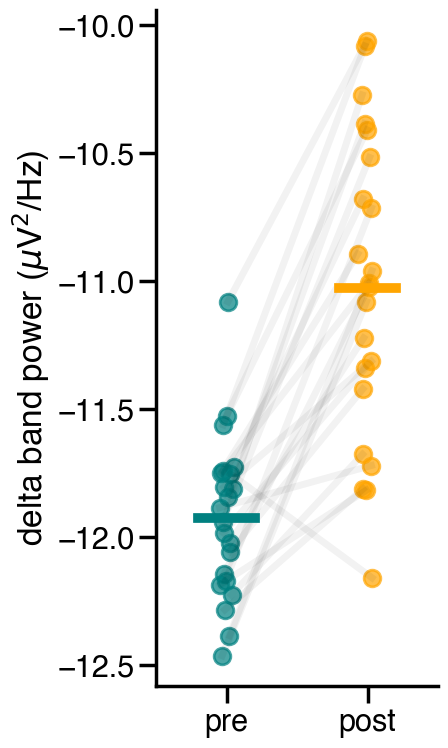

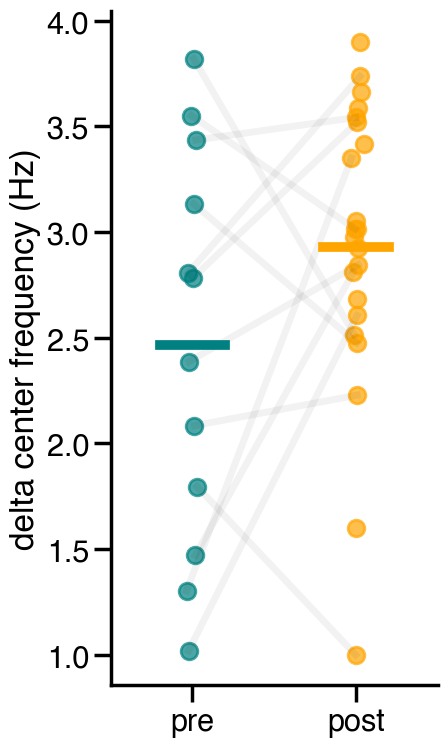

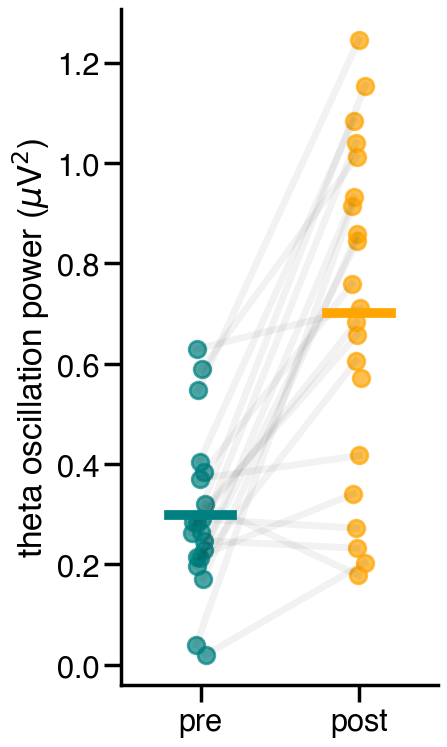

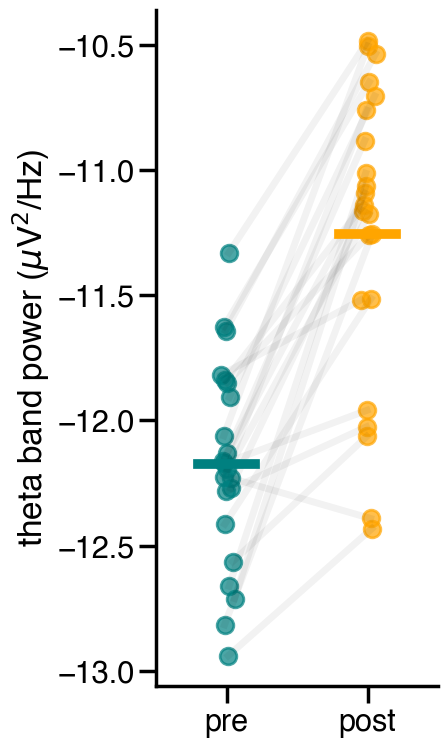

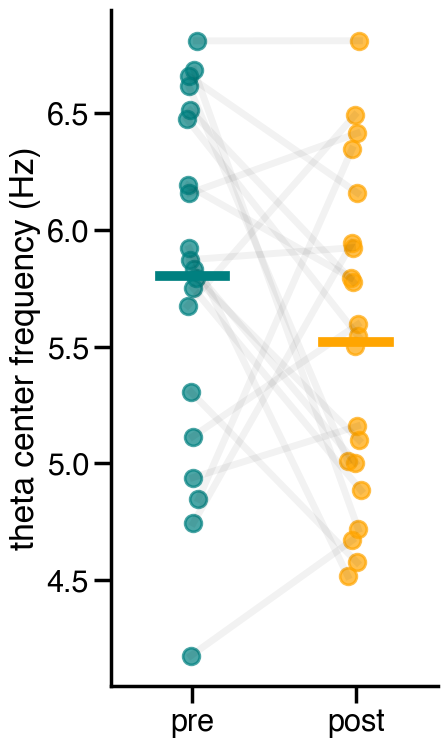

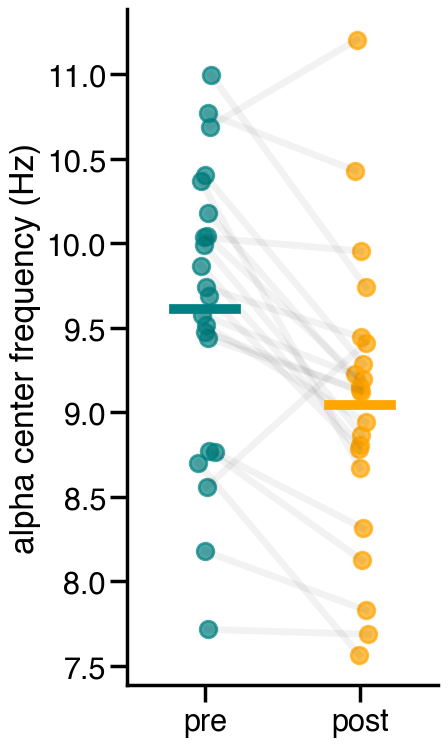

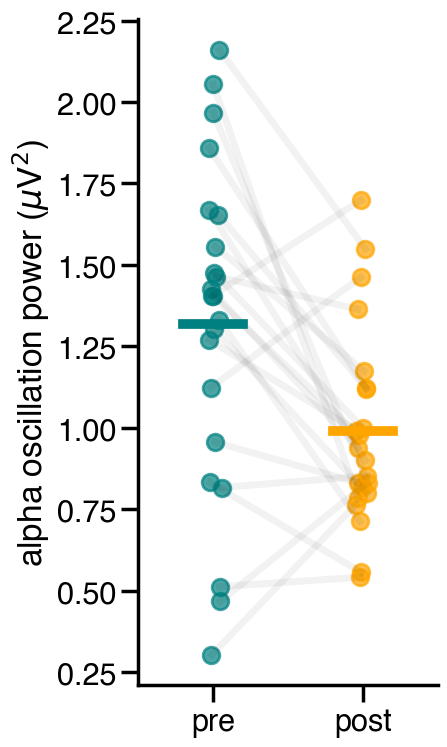

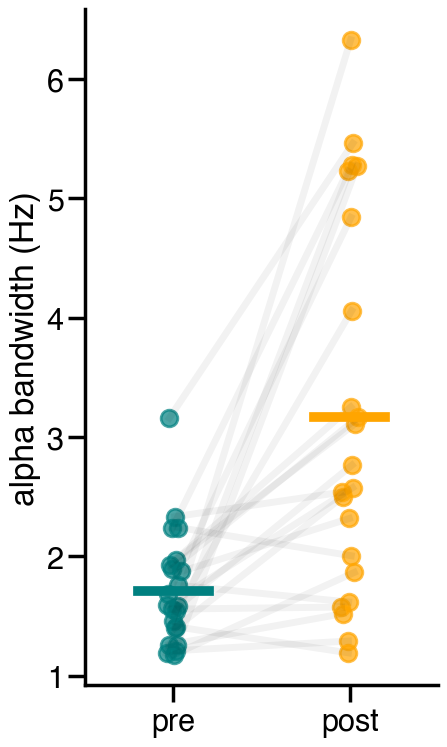

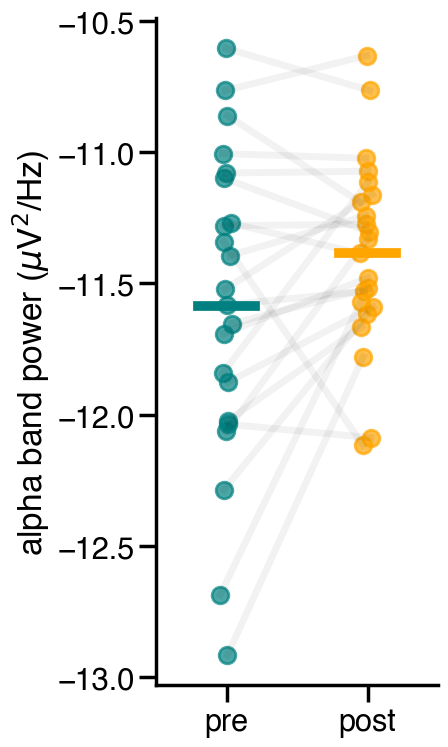

In [14]:
SAVE_FIG = False
fig_path = '../figures/'

# %matplotlib qt

features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'delta_cf', 'theta_amp', 'theta_bp', 'theta_cf',
            'alpha_cf', 'alpha_amp', 'alpha_bw', 'alpha_bp']

labels = ['aperiodic exponent ($\mu$V$^2$/Hz)', 'aperiodic offset ($\mu$V$^2$)',
          'delta oscillation power ($\mu$V$^2$)', 'delta band power ($\mu$V$^2$/Hz)', 'delta center frequency (Hz)',
          'theta oscillation power ($\mu$V$^2$)', 'theta band power ($\mu$V$^2$/Hz)', 'theta center frequency (Hz)',
          'alpha center frequency (Hz)', 'alpha oscillation power ($\mu$V$^2$)',
          'alpha bandwidth (Hz)', 'alpha band power ($\mu$V$^2$/Hz)' ]



for feature, label in zip(features, labels):
    plot_feature_prepost(exp_df_mean, feature=feature)
    plt.ylabel(label)
    plt.tight_layout()
    sns.despine()
    plt.show()
    
    if SAVE_FIG:
        plt.savefig(fig_path+feature+'.pdf', format='pdf')

### Figure-Specific Axes

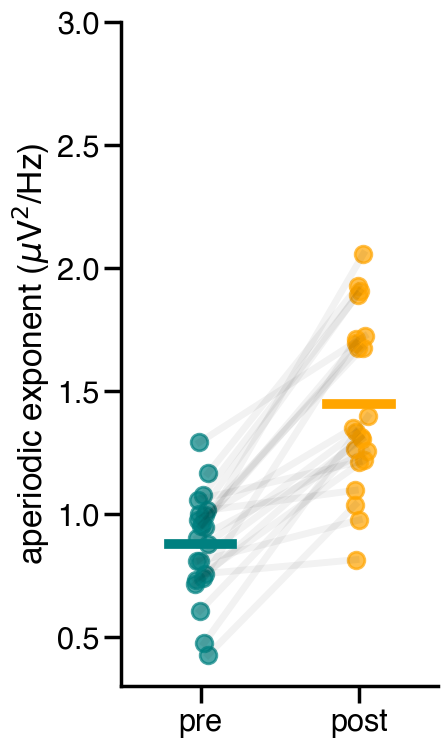

In [15]:
plot_feature_prepost(exp_df_mean, feature='exponent')
plt.ylabel('aperiodic exponent ($\mu$V$^2$/Hz)')
plt.ylim(0.3, 3.0)
sns.despine()
plt.tight_layout()
plt.show()

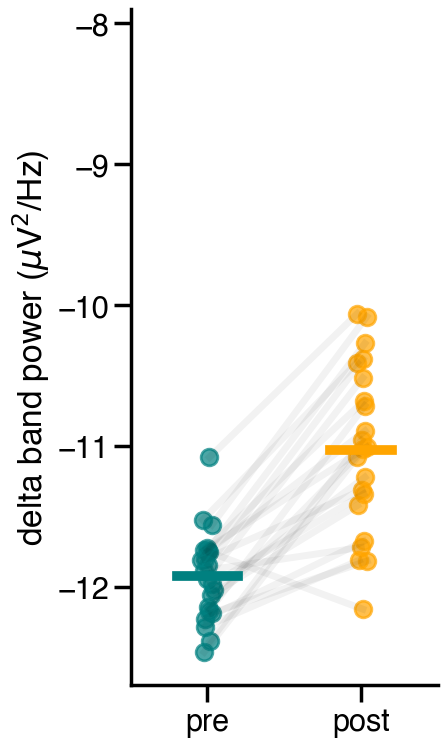

In [16]:
plot_feature_prepost(exp_df_mean, feature='delta_bp')
plt.ylabel('delta band power ($\mu$V$^2$/Hz)')
plt.ylim(-12.7, -7.9)
sns.despine()
plt.tight_layout()
plt.show()

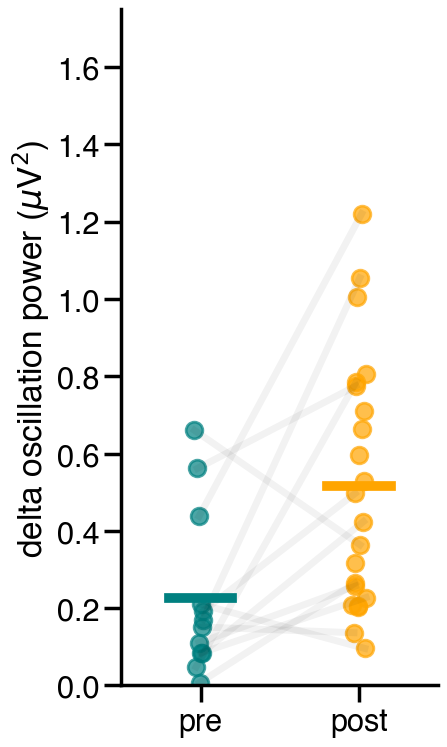

In [17]:
plot_feature_prepost(exp_df_mean, feature='delta_amp')
plt.ylabel('delta oscillation power ($\mu$V$^2$)')
plt.ylim(0, 1.75)
sns.despine()
plt.tight_layout()
plt.show()

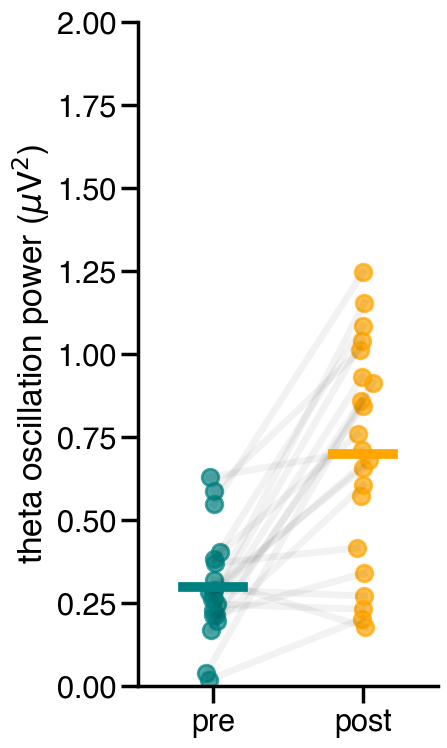

In [18]:
plot_feature_prepost(exp_df_mean, feature='theta_amp')
plt.ylabel('theta oscillation power ($\mu$V$^2$)')
plt.ylim(0, 2.0)
sns.despine()
plt.tight_layout()
plt.show()

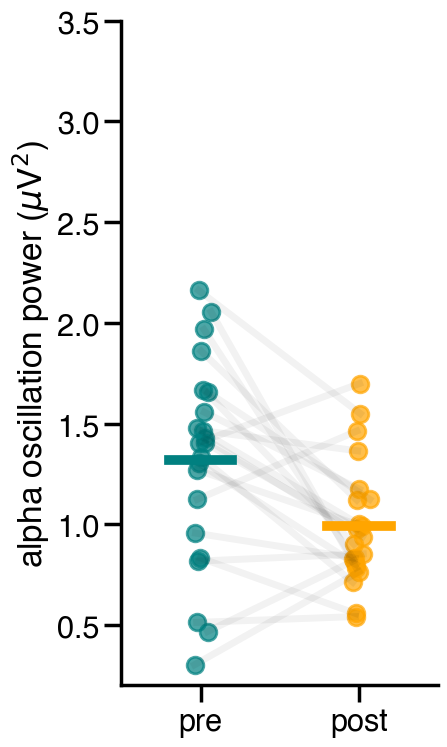

In [19]:
plot_feature_prepost(exp_df_mean, feature='alpha_amp')
plt.ylabel('alpha oscillation power ($\mu$V$^2$)')
plt.ylim(0.2, 3.5)
sns.despine()
plt.tight_layout()
plt.show()

## Power Spectra (specparam fits)

In [20]:
fits_pre_mean = np.nanmean(fits_pre_included, axis=1)
fits_post_mean = np.nanmean(fits_post_included, axis=1)

fits_pre_grand_mean = np.nanmean(fits_pre_included, axis=(0,1))
fits_post_grand_mean = np.nanmean(fits_post_included, axis=(0,1))

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_11595/1731462785.py:1: RuntimeWarning: Mean of empty slice
  fits_pre_mean = np.nanmean(fits_pre_included, axis=1)
/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_11595/1731462785.py:2: RuntimeWarning: Mean of empty slice
  fits_post_mean = np.nanmean(fits_post_included, axis=1)


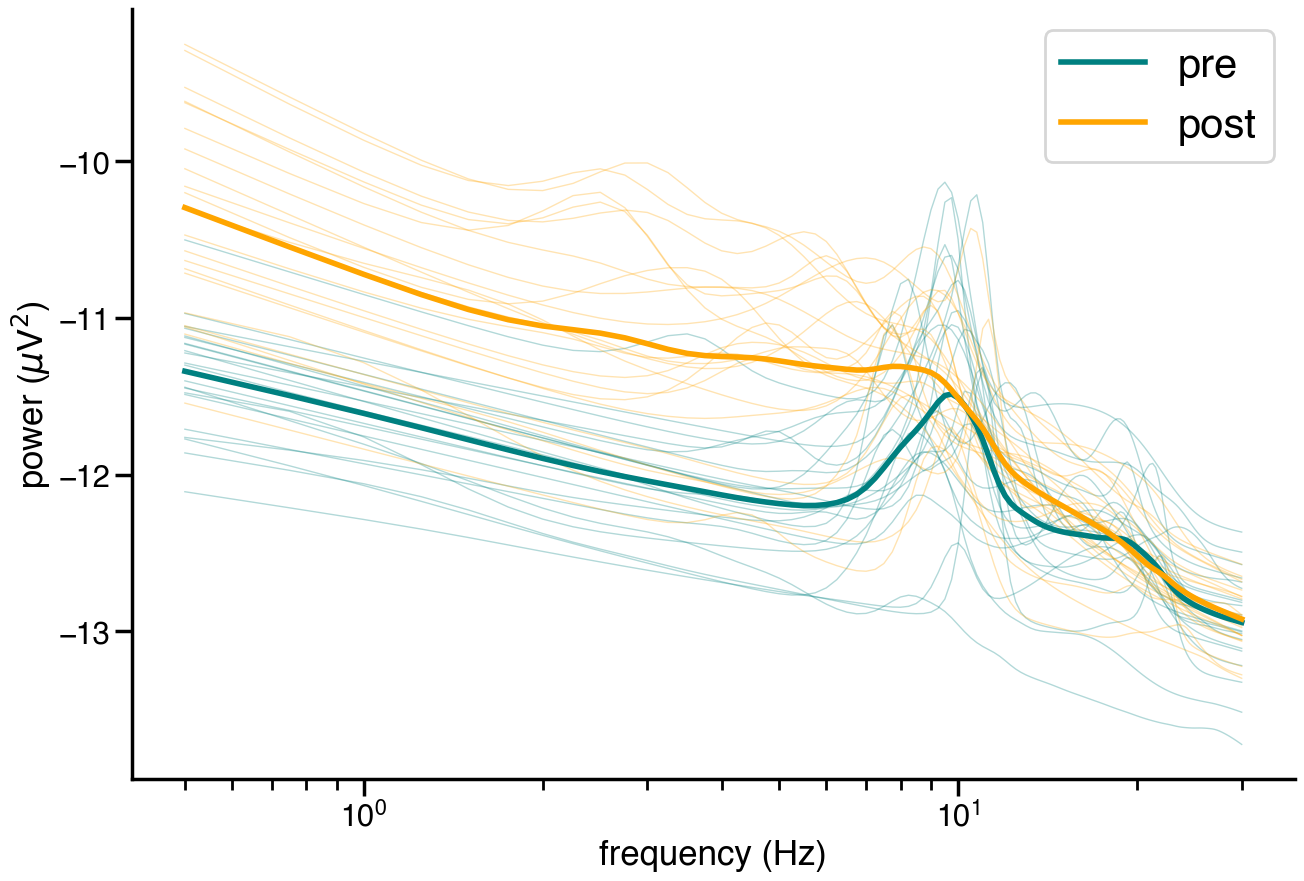

<Figure size 640x480 with 0 Axes>

In [21]:
sns.set_context('poster')
plt.figure(figsize=[15,10])

# plot patient pre
for patient in range(0, fits_pre_mean.shape[0]):
    plt.plot(freq_axis[2:121], fits_pre_mean[patient], color='teal', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, fits_post_mean.shape[0]):
    plt.plot(freq_axis[2:121], fits_post_mean[patient], color='orange', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[2:121], fits_pre_grand_mean, color='teal', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[2:121], fits_post_grand_mean, color='orange', linewidth = 4, label='post')


plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})

sns.despine()
plt.show()
plt.savefig(fig_path+'spectra_fits.pdf', format='pdf')

## Plot Spectra (raw PSDs)

In [22]:
psd_pre_mean = np.nanmean(psd_pre_included, axis=1)
psd_post_mean = np.nanmean(psd_post_included, axis=1)

psd_pre_grand_mean = np.nanmean(psd_pre_included, axis=(0,1))
psd_post_grand_mean = np.nanmean(psd_post_included, axis=(0,1))

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_11595/4288182120.py:1: RuntimeWarning: Mean of empty slice
  psd_pre_mean = np.nanmean(psd_pre_included, axis=1)
/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_11595/4288182120.py:2: RuntimeWarning: Mean of empty slice
  psd_post_mean = np.nanmean(psd_post_included, axis=1)


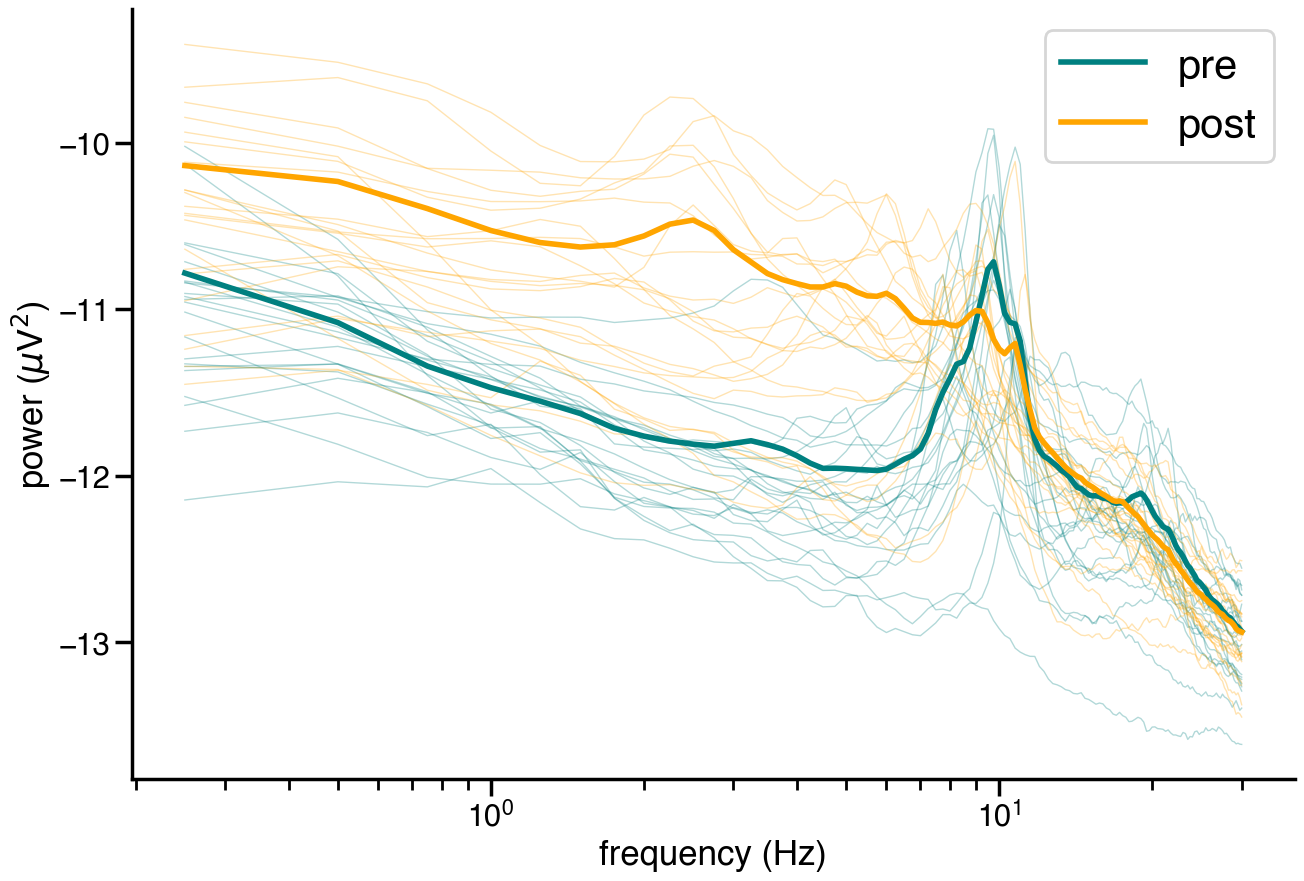

In [23]:
# plot patient pre

sns.set_context('poster')
plt.figure(figsize=[15,10])

for patient in range(0, psd_pre_mean.shape[0]):
    plt.plot(freq_axis[1:121], np.log10(psd_pre_mean[patient,1:121]), color='teal', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, psd_post_mean.shape[0]):
    plt.plot(freq_axis[1:121], np.log10(psd_post_mean[patient,1:121]), color='orange', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[1:121], np.log10(psd_pre_grand_mean[1:121]), color='teal', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[1:121], np.log10(psd_post_grand_mean[1:121]), color='orange', linewidth = 4, label='post')

plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})


sns.despine()

plt.show()

# Statistics

### Exponent: Pre/Post

**Normality**

In [24]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['exponent'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['exponent'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.971783  0.751975    True
          W     pval  normal
0  0.953723  0.37355    True


In [25]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: 0.88 std: 0.21
post: 1.45 std: 0.33


**Distribution of means pre vs. post**

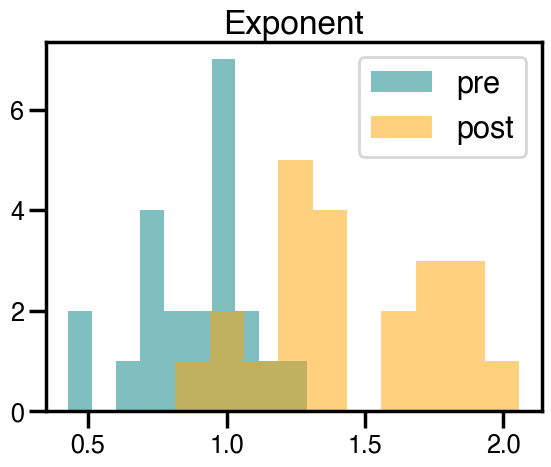

In [26]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Exponent')
plt.show()

**Wilcoxon Test**

In [27]:
print(wilcoxon(means_pre, means_post))

          W-val alternative         p-val  RBC     CLES
Wilcoxon    0.0   two-sided  4.768372e-07 -1.0  0.06405


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.08604999999999999 

               T  dof alternative         p-val          CI95%   cohen-d  \
T-test -9.066168   21   two-sided  1.047680e-08  [-0.7, -0.44]  2.001261   

             BF10  power  
T-test  1.218e+06    1.0  


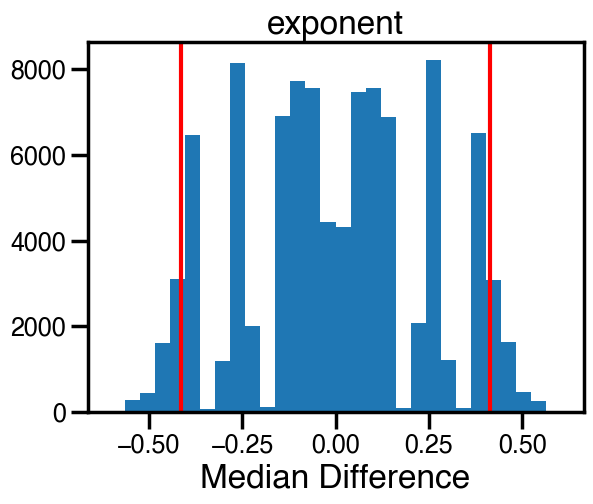

In [28]:
perm_test(exp_df_mean, feature='exponent')

### Offset: Pre/Post

**Normality**

In [29]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['offset'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['offset'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.964509  0.585373    True
          W      pval  normal
0  0.974519  0.812593    True


**Distribution of means pre vs. post**

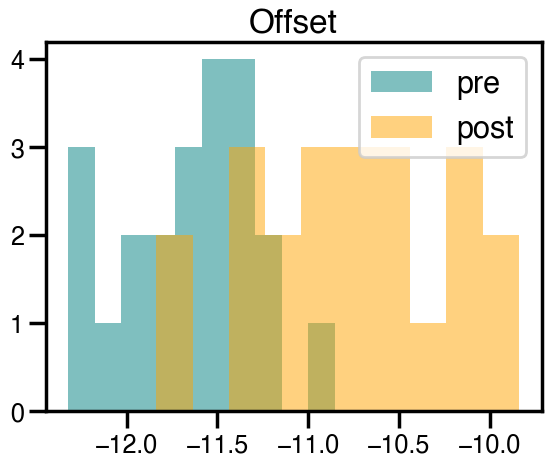

In [30]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Offset')
plt.show()

**Wilcoxon Test**

In [31]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val      RBC      CLES
Wilcoxon    2.0   two-sided  0.000001 -0.98419  0.103306


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.00083 

               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -9.005219   21   two-sided  1.174084e-08  [-1.07, -0.67]  1.830902   

             BF10  power  
T-test  1.095e+06    1.0  


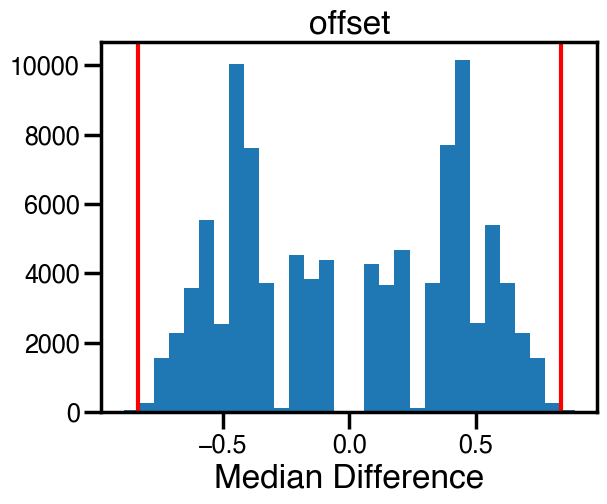

In [32]:
perm_test(exp_df_mean, feature='offset')

### Delta Oscillatory Power: Pre/Post

**Normality**

In [33]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_amp'].values # .dropna(how="any")
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_amp'].values

# # normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.835536  0.024446   False
          W      pval  normal
0  0.927464  0.108642    True


In [34]:
print('delta osc pre:')
print(exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_amp'].describe())

delta osc pre:
count    12.000000
mean      0.226376
std       0.210853
min       0.007236
25%       0.084549
50%       0.160900
75%       0.266959
max       0.660009
Name: delta_amp, dtype: float64


In [35]:
print('delta osc post:')
print(exp_df_mean[exp_df_mean['pre_post']=='post']['delta_amp'].describe())

delta osc post:
count    22.000000
mean      0.515698
std       0.324592
min       0.095825
25%       0.234924
50%       0.460372
75%       0.758967
max       1.220475
Name: delta_amp, dtype: float64


In [36]:
print('pre: ' + str(round(np.nanmean(means_pre),2)) + ' std: ' + str(round(np.nanstd(means_pre),2)))
print('post: ' + str(round(np.nanmean(means_post),2)) + ' std: ' + str(round(np.nanstd(means_post),2)))



pre: 0.23 std: 0.2
post: 0.52 std: 0.32


**Distribution of means pre vs. post**

This one is tricky to do stats for because the pre has so few channels that even detect a delta oscillation. When we try to keep the 0's instead of NaNs, the Wilcoxon test fails due to 'ties'. Therefore, we are keeping the NaNs, and will just report the permutation test for statistics.

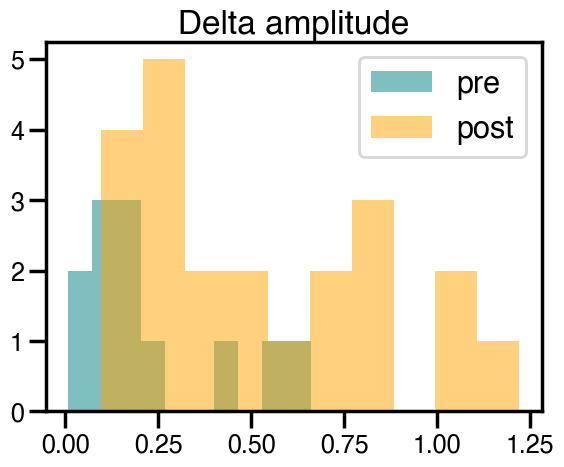

In [37]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta amplitude')
plt.show()

**Wilcoxon**

In [38]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val      RBC      CLES
Wilcoxon   10.0   two-sided  0.020996 -0.74359  0.222222


In [39]:
cliffs_delta(means_pre, means_post)

(-0.2644628099173554, 'small')

**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -2.694211   11   two-sided  0.020872  [-0.51, -0.05]  0.940319  3.277   

           power  
T-test  0.842106  


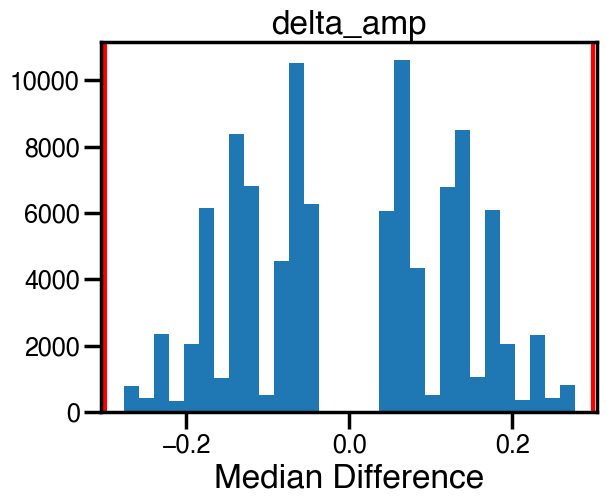

In [40]:
# this test can't be run because there's only one value
perm_test(exp_df_mean, feature='delta_amp')

### Delta Bandpower: Pre/Post

**Normality**

In [41]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.964059  0.575385    True
          W      pval  normal
0  0.971237  0.739519    True


In [42]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -11.92 std: 0.31
post: -11.03 std: 0.58


#### Distribution of means pre vs. post

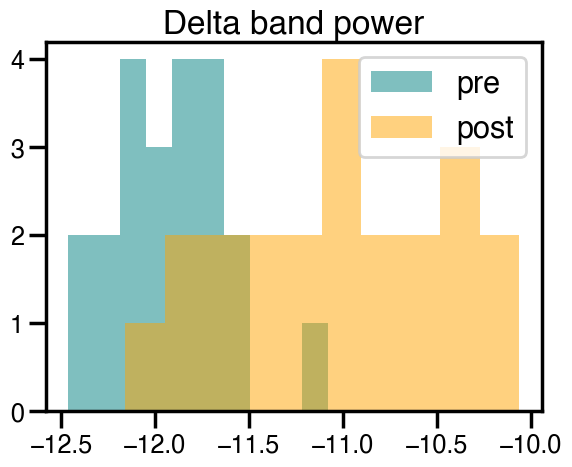

In [43]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta band power')
plt.show()

**Wilcoxon Test**

In [44]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon    3.0   two-sided  0.000002 -0.976285  0.088843


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.00084 

               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -8.269111   21   two-sided  4.825668e-08  [-1.12, -0.67]  1.880913   

             BF10  power  
T-test  2.944e+05    1.0  


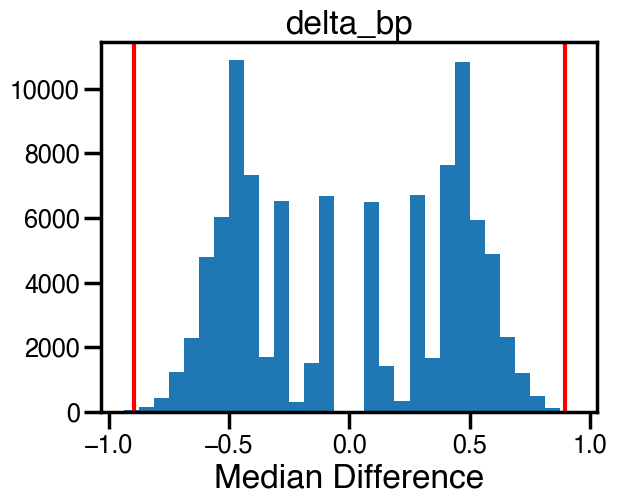

In [45]:
perm_test(exp_df_mean, feature='delta_bp')

### Delta Center Frequency: Pre/Post

**Normality**

In [46]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.953309  0.685749    True
          W      pval  normal
0  0.918989  0.072442    True


#### Distribution of means pre vs. post

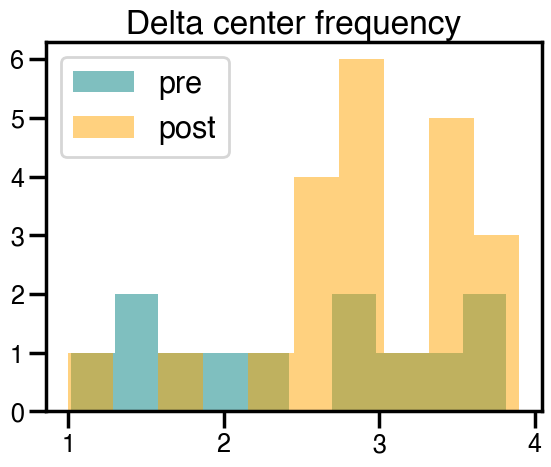

In [47]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta center frequency')
plt.show()

**Wilcoxon Test**

In [48]:
print(wilcoxon(means_pre, means_post))

          W-val alternative    p-val       RBC      CLES
Wilcoxon   25.0   two-sided  0.30127 -0.358974  0.395833


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.35473 

               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test -1.126905   11   two-sided  0.283765  [-1.0, 0.32]  0.399113  0.486   

           power  
T-test  0.243754  


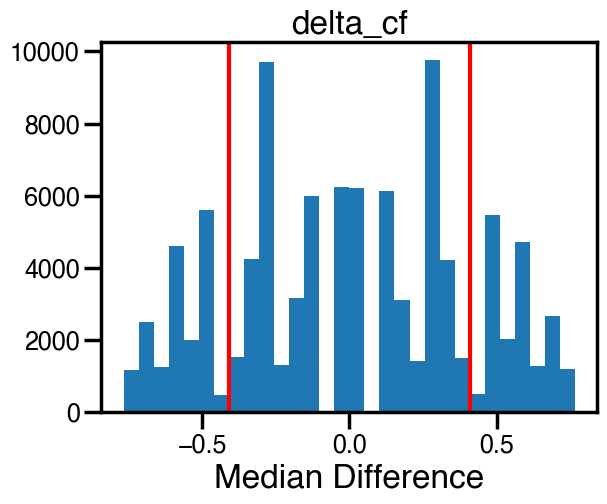

In [49]:
perm_test(exp_df_mean, feature='delta_cf')

### Theta Oscillatory Power: Pre/Post

**Normality**

In [50]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_amp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.937012  0.210426    True
          W      pval  normal
0  0.951922  0.370155    True


In [51]:
print('pre: ' + str(round(np.nanmean(means_pre),2)) + ' std: ' + str(round(np.nanstd(means_pre),2)))
print('post: ' + str(round(np.nanmean(means_post),2)) + ' std: ' + str(round(np.nanstd(means_post),2)))

pre: 0.3 std: 0.15
post: 0.7 std: 0.32


#### Distribution of means pre vs. post

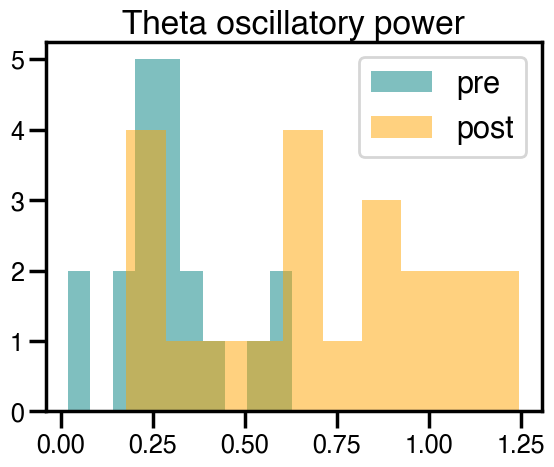

In [52]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta oscillatory power')
plt.show()

**Wilcoxon Test**

In [53]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC   CLES
Wilcoxon    9.0   two-sided  0.000063 -0.914286  0.165


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

              T  dof alternative     p-val           CI95%  cohen-d      BF10  \
T-test -5.65128   19   two-sided  0.000019  [-0.56, -0.26]  1.55462  1235.394   

        power  
T-test    1.0  


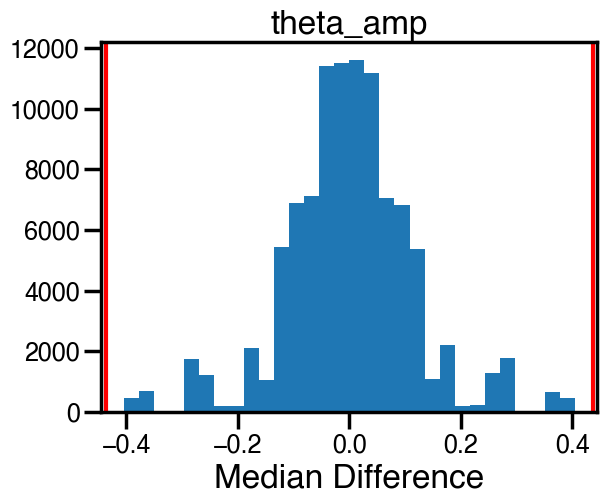

In [54]:
perm_test(exp_df_mean, feature='theta_amp')

### Theta Bandpower: Pre/Post

**Normality**

In [55]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

         W      pval  normal
0  0.97969  0.911075    True
          W      pval  normal
0  0.919864  0.075529    True


In [56]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -12.17 std: 0.4
post: -11.25 std: 0.58


#### Distribution of means pre vs. post

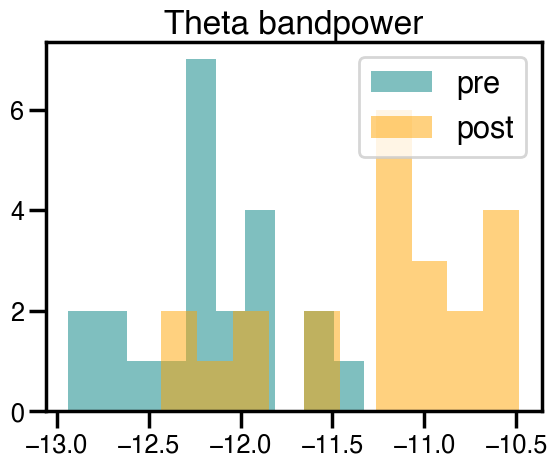

In [57]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta bandpower')
plt.show()

**Wilcoxon Test**

In [58]:
print(wilcoxon(means_pre, means_post))

          W-val alternative         p-val       RBC      CLES
Wilcoxon    1.0   two-sided  9.536743e-07 -0.992095  0.117769


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -8.485694   21   two-sided  3.160559e-08  [-1.15, -0.69]  1.805628   

             BF10  power  
T-test  4.361e+05    1.0  


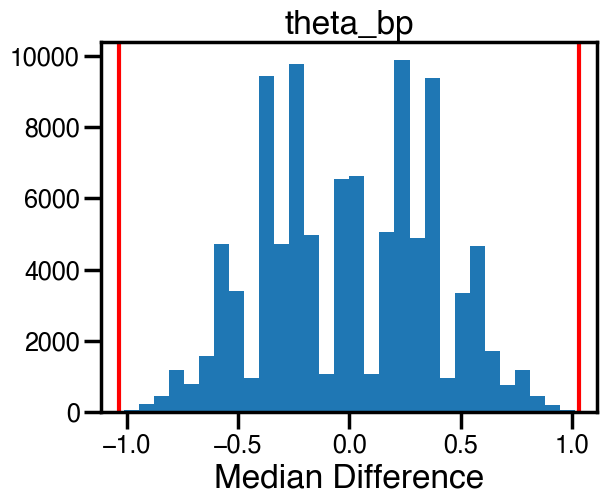

In [59]:
perm_test(exp_df_mean, feature='theta_bp')

### Theta Center Frequency: Pre/Post

**Normality**

In [60]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.943532  0.279363    True
          W      pval  normal
0  0.954938  0.420557    True


#### Distribution of means pre vs. post

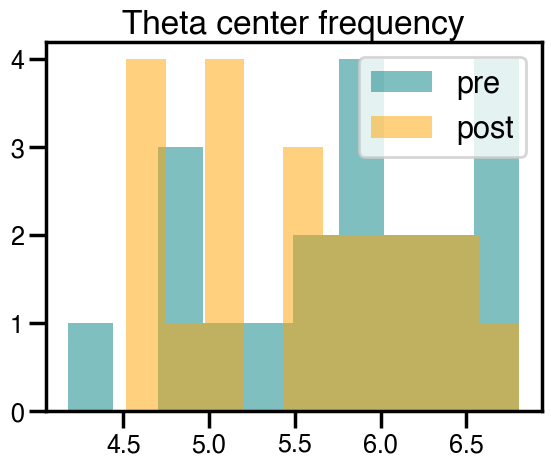

In [61]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta center frequency')
plt.show()

**Wilcoxon Test**

In [62]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC    CLES
Wilcoxon   69.0   two-sided  0.189348  0.342857  0.6175


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.35633000000000004 

               T  dof alternative    p-val          CI95%   cohen-d   BF10  \
T-test  1.371239   19   two-sided  0.18628  [-0.15, 0.71]  0.387544  0.524   

          power  
T-test  0.37681  


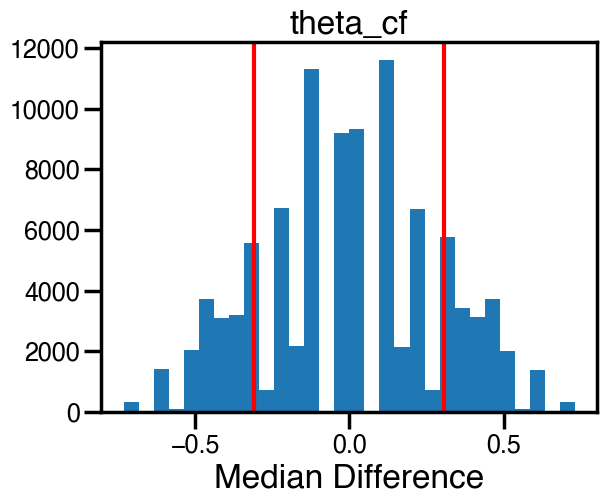

In [63]:
perm_test(exp_df_mean, feature='theta_cf')

### Alpha Oscillatory Power: Pre/Post

**Normality**

In [64]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_amp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.962978  0.551718    True
          W      pval  normal
0  0.927036  0.106438    True


In [65]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: 1.32 std: 0.49
post: 0.99 std: 0.3


#### Distribution of means pre vs. post

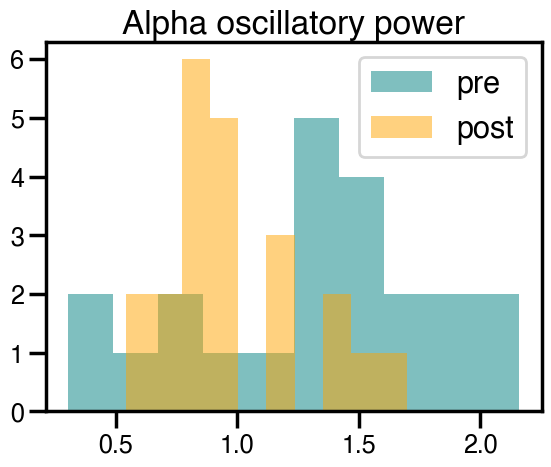

In [66]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha oscillatory power')
plt.show()

**Wilcoxon Test**

In [67]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val     RBC     CLES
Wilcoxon   39.0   two-sided  0.003239  0.6917  0.71281


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative     p-val         CI95%  cohen-d    BF10  \
T-test  3.331855   21   two-sided  0.003165  [0.12, 0.53]  0.78449  13.197   

           power  
T-test  0.939035  


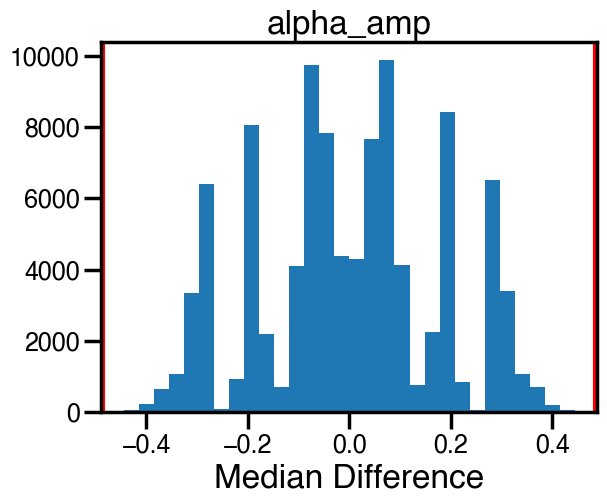

In [68]:
perm_test(exp_df_mean, feature='alpha_amp')

### Alpha Bandpower: Pre/Post

**Normality**

In [69]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.975177  0.826532    True
          W      pval  normal
0  0.978059  0.883132    True


In [70]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -11.59 std: 0.58
post: -11.38 std: 0.36


#### Distribution of means pre vs. post

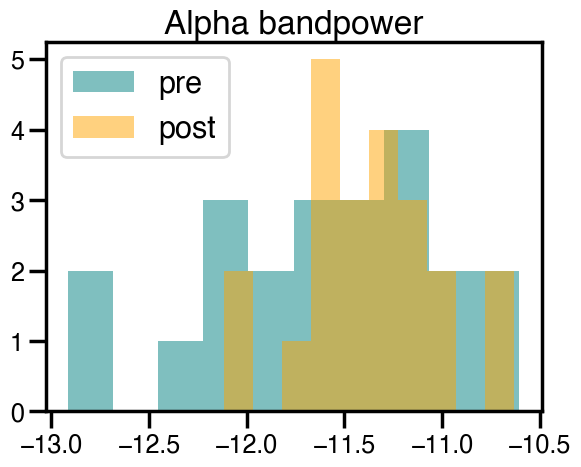

In [71]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha bandpower')
plt.show()

**Wilcoxon Test**

In [72]:
print(wilcoxon(means_pre, means_post))

          W-val alternative    p-val       RBC      CLES
Wilcoxon   68.0   two-sided  0.05869 -0.462451  0.409091


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.00054 

               T  dof alternative     p-val        CI95%   cohen-d   BF10  \
T-test -2.064271   21   two-sided  0.051564  [-0.4, 0.0]  0.405245  1.311   

           power  
T-test  0.441951  


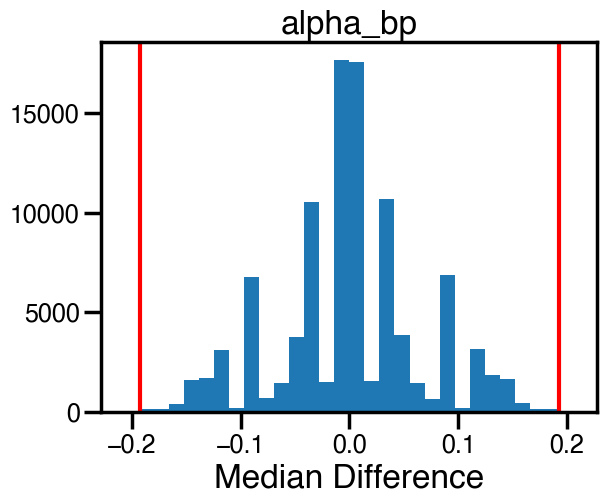

In [73]:
perm_test(exp_df_mean, feature='alpha_bp')

### Alpha Center Frequency: Pre/Post

**Normality**

In [74]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.963978  0.573582    True
          W      pval  normal
0  0.958399  0.457611    True




#### Distribution of means pre vs. post

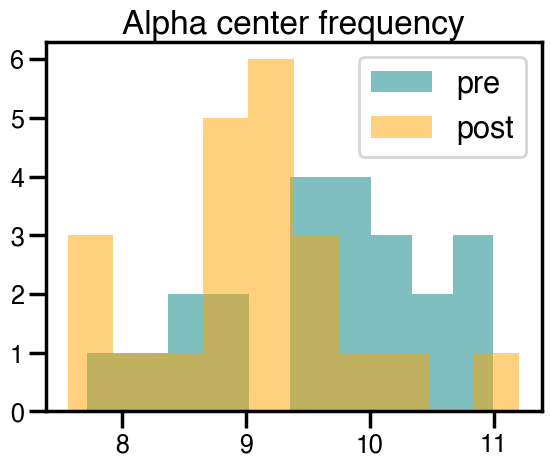

In [75]:
plt.hist(means_pre, color = 'teal', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'orange', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha center frequency')
plt.show()

**Wilcoxon Test**

In [76]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   24.0   two-sided  0.000362  0.810277  0.698347


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.00053 

               T  dof alternative     p-val         CI95%   cohen-d     BF10  \
T-test  4.528218   21   two-sided  0.000184  [0.31, 0.83]  0.663718  159.454   

           power  
T-test  0.843288  


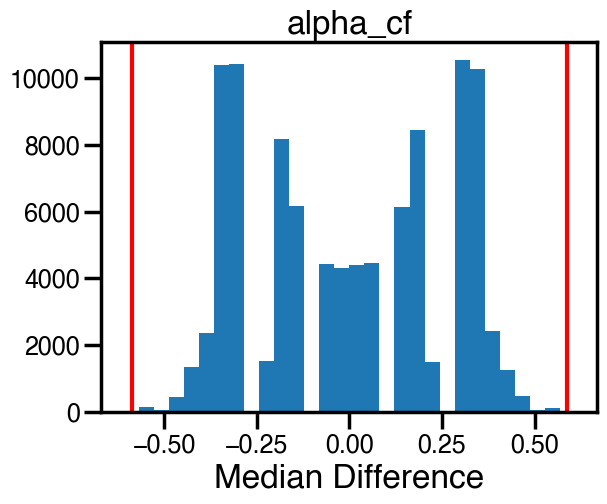

In [77]:
perm_test(exp_df_mean, feature='alpha_cf')

## Presence/Absence/Percentage of Channels with Oscillations

We are determining what % of channels have a delta/theta/alpha oscillation per participant, per pre/post

### Delta Percentage

In [78]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a delta oscillation)

features = ['patient','pre_post','channel','delta_cf']
exp_df_delta_osc = exp_df_included[features]
exp_df_delta_osc['delta_present'] = exp_df_delta_osc['delta_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_11595/259686611.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_delta_osc['delta_present'] = exp_df_delta_osc['delta_cf'].notna()


In [79]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a delta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_delta = exp_df_delta_osc.groupby(['patient', 'pre_post'])['delta_present'].sum().values
ch_total = exp_df_delta_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_delta_perc = ch_delta/ch_total

In [80]:
# Add the delta oscillation percentages to the other df to determine which value corresponds to pre/post

delta_osc_perc = pd.DataFrame(exp_df_delta_osc.groupby(['patient', 'pre_post'], as_index=False)['delta_present'].sum())
delta_osc_perc['ch_delta_perc'] = ch_delta_perc


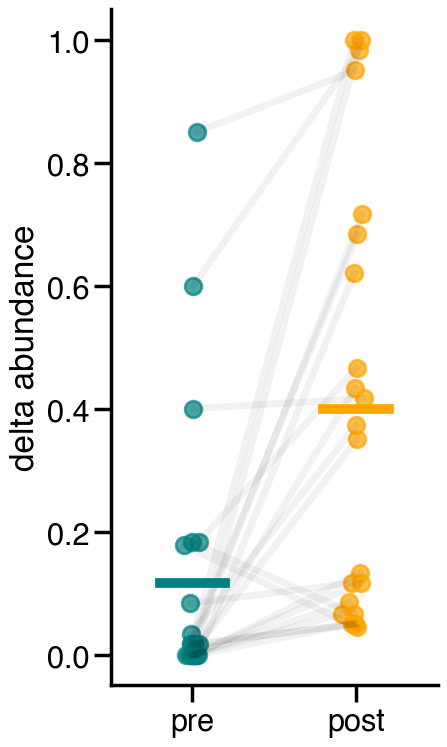

In [81]:
plot_feature_prepost(delta_osc_perc, feature='ch_delta_perc')
plt.ylabel('delta abundance')
plt.tight_layout()
sns.despine()
plt.show()

**Normality**

In [82]:
perc_delta_pre = delta_osc_perc[delta_osc_perc['pre_post']=='pre']['ch_delta_perc'].values
perc_delta_post = delta_osc_perc[delta_osc_perc['pre_post']=='post']['ch_delta_perc'].values

# normality test
print(normality(perc_delta_pre, method='shapiro'))
print(normality(perc_delta_post, method='shapiro'))

          W      pval  normal
0  0.601801  0.000001   False
          W      pval  normal
0  0.844232  0.002689   False


In [83]:
# pre delta abundance descrition:
print('pre delta abundance')
print(delta_osc_perc[delta_osc_perc['pre_post']=='pre']['ch_delta_perc'].describe())

pre delta abundance
count    22.000000
mean      0.117197
std       0.223432
min       0.000000
25%       0.000000
50%       0.016667
75%       0.154167
max       0.850000
Name: ch_delta_perc, dtype: float64


In [84]:
# post delta abundance descrition:
print('post delta abundance')
print(delta_osc_perc[delta_osc_perc['pre_post']=='post']['ch_delta_perc'].describe())

post delta abundance
count    22.000000
mean      0.398778
std       0.355102
min       0.044444
25%       0.071277
50%       0.361441
75%       0.667672
max       1.000000
Name: ch_delta_perc, dtype: float64


In [85]:
print('pre: ' + str(round(perc_delta_pre.mean(),2)) + ' std: ' + str(round(perc_delta_pre.std(),2)))
print('post: ' + str(round(perc_delta_post.mean(),2)) + ' std: ' + str(round(perc_delta_post.std(),2)))

pre: 0.12 std: 0.22
post: 0.4 std: 0.35


**Wilcoxon Test**

In [86]:
print(wilcoxon(perc_delta_pre, perc_delta_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   20.5   two-sided  0.000177 -0.837945  0.167355


In [87]:
cliffs_delta(perc_delta_pre, perc_delta_post)

(-0.6652892561983471, 'large')

**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative     p-val           CI95%   cohen-d    BF10  \
T-test -3.973545   21   two-sided  0.000692  [-0.43, -0.13]  0.949158  49.404   

           power  
T-test  0.988711  


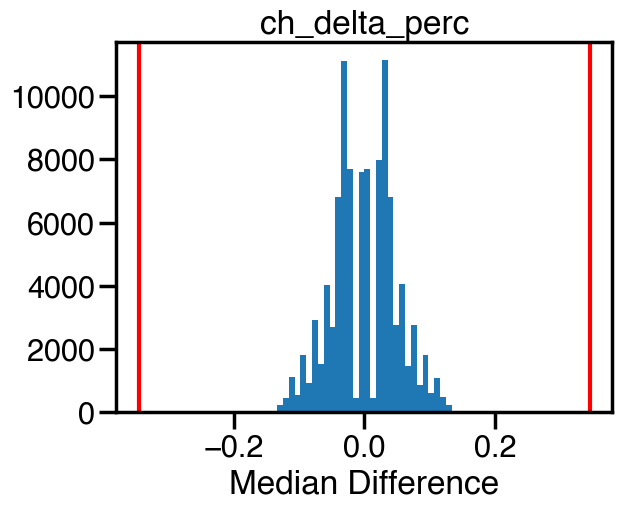

In [88]:
perm_test(delta_osc_perc, feature='ch_delta_perc')

### Theta Percentage

In [89]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a theta oscillation)

features = ['patient','pre_post','channel','theta_cf']
exp_df_theta_osc = exp_df_included[features]
exp_df_theta_osc['theta_present'] = exp_df_theta_osc['theta_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_11595/2939216184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_theta_osc['theta_present'] = exp_df_theta_osc['theta_cf'].notna()


In [90]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a theta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_theta = exp_df_theta_osc.groupby(['patient', 'pre_post'])['theta_present'].sum().values
ch_total = exp_df_theta_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_theta_perc = ch_theta/ch_total

In [91]:
# Add the theta oscillation percentages to the other df to determine which value corresponds to pre/post

theta_osc_perc = pd.DataFrame(exp_df_theta_osc.groupby(['patient', 'pre_post'], as_index=False)['theta_present'].sum())
theta_osc_perc['ch_theta_perc'] = ch_theta_perc

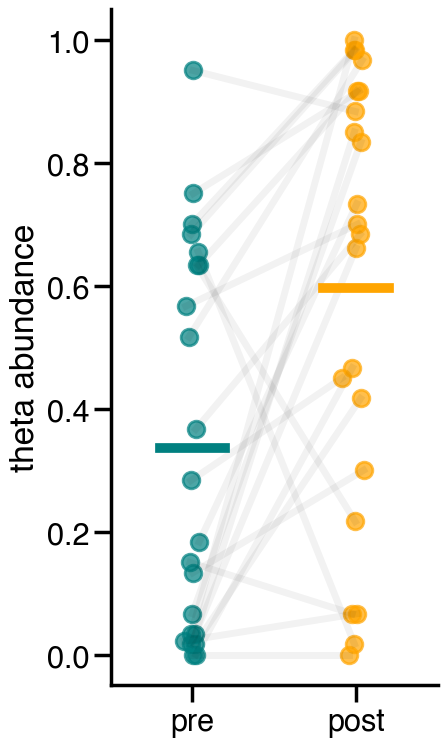

In [92]:
plot_feature_prepost(theta_osc_perc, feature='ch_theta_perc')
plt.ylabel('theta abundance')
sns.despine()
plt.tight_layout()
plt.show()

In [93]:
perc_theta_pre = theta_osc_perc[theta_osc_perc['pre_post']=='pre']['ch_theta_perc'].values
perc_theta_post = theta_osc_perc[theta_osc_perc['pre_post']=='post']['ch_theta_perc'].values

In [94]:
print('pre: ' + str(round(perc_theta_pre.mean(),2)) + ' std: ' + str(round(perc_theta_pre.std(),2)))
print('post: ' + str(round(perc_theta_post.mean(),2)) + ' std: ' + str(round(perc_theta_post.std(),2)))

pre: 0.34 std: 0.31
post: 0.6 std: 0.34


In [95]:
print('theta abundance pre')
print(theta_osc_perc[theta_osc_perc['pre_post']=='pre']['ch_theta_perc'].describe())

theta abundance pre
count    22.000000
mean      0.336107
std       0.312633
min       0.000000
25%       0.033333
50%       0.233333
75%       0.633333
max       0.950000
Name: ch_theta_perc, dtype: float64


In [96]:
print('theta abundance post')
print(theta_osc_perc[theta_osc_perc['pre_post']=='post']['ch_theta_perc'].describe())

theta abundance post
count    22.000000
mean      0.595981
std       0.352105
min       0.000000
25%       0.329167
50%       0.691667
75%       0.908333
max       1.000000
Name: ch_theta_perc, dtype: float64


**Wilcoxon Test**

In [97]:
print(wilcoxon(perc_theta_pre, perc_theta_post))
print(normality(perc_theta_pre, method='shapiro'))
print(normality(perc_theta_post, method = 'shapiro'))

          W-val alternative     p-val      RBC      CLES
Wilcoxon   35.0   two-sided  0.005422 -0.69697  0.274793
          W      pval  normal
0  0.866219  0.006662   False
          W      pval  normal
0  0.883899  0.014351   False


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [98]:
cliffs_delta(perc_theta_pre, perc_theta_post)

(-0.45041322314049587, 'medium')

**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

              T  dof alternative     p-val           CI95%   cohen-d    BF10  \
T-test -3.20006   21   two-sided  0.004303  [-0.43, -0.09]  0.780513  10.148   

           power  
T-test  0.936867  


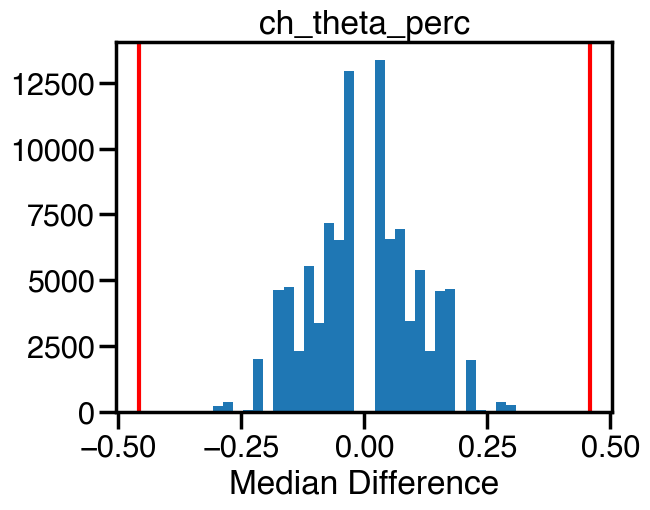

In [99]:
perm_test(theta_osc_perc, feature='ch_theta_perc')

### Alpha Percentage

In [100]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have an alpha oscillation)

features = ['patient','pre_post','channel','alpha_cf']
exp_df_alpha_osc = exp_df_included[features]
exp_df_alpha_osc['alpha_present'] = exp_df_alpha_osc['alpha_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_11595/4032763983.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_alpha_osc['alpha_present'] = exp_df_alpha_osc['alpha_cf'].notna()


In [101]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a theta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_alpha = exp_df_alpha_osc.groupby(['patient', 'pre_post'])['alpha_present'].sum().values
ch_total = exp_df_alpha_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_alpha_perc = ch_alpha/ch_total

In [102]:
# Add the alpha oscillation percentages to the other df to determine which value corresponds to pre/post

alpha_osc_perc = pd.DataFrame(exp_df_alpha_osc.groupby(['patient', 'pre_post'], as_index=False)['alpha_present'].sum())
alpha_osc_perc['ch_alpha_perc'] = ch_alpha_perc

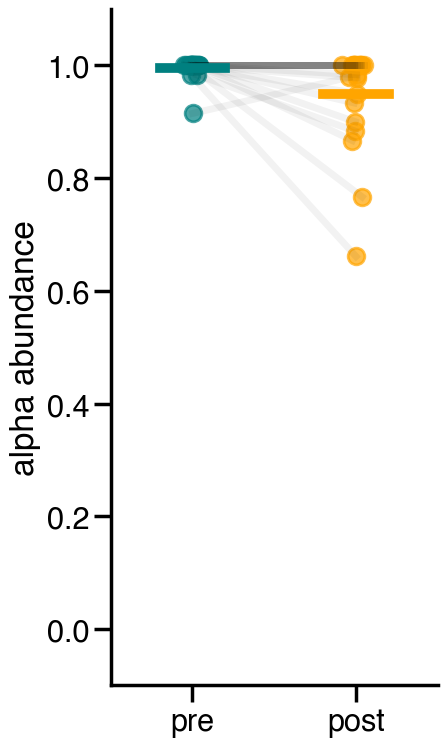

In [103]:
plot_feature_prepost(alpha_osc_perc, feature='ch_alpha_perc')
plt.ylabel('alpha abundance')
plt.ylim([-0.1,1.1])
sns.despine()
plt.tight_layout()
plt.show()

In [104]:
perc_alpha_pre = alpha_osc_perc[alpha_osc_perc['pre_post']=='pre']['ch_alpha_perc'].values
perc_alpha_post = alpha_osc_perc[alpha_osc_perc['pre_post']=='post']['ch_alpha_perc'].values

In [105]:
print('pre: ' + str(round(perc_alpha_pre.mean(),2)) + ' std: ' + str(round(perc_alpha_pre.std(),2)))
print('post: ' + str(round(perc_alpha_post.mean(),2)) + ' std: ' + str(round(perc_alpha_post.std(),2)))

pre: 0.99 std: 0.02
post: 0.95 std: 0.09


In [106]:
print('alpha abundance pre')
print(alpha_osc_perc[alpha_osc_perc['pre_post']=='pre']['ch_alpha_perc'].describe())

alpha abundance pre
count    22.000000
mean      0.994604
std       0.018475
min       0.914894
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: ch_alpha_perc, dtype: float64


In [107]:
print('alpha abundance post')
print(alpha_osc_perc[alpha_osc_perc['pre_post']=='post']['ch_alpha_perc'].describe())

alpha abundance post
count    22.000000
mean      0.950039
std       0.088371
min       0.661017
25%       0.937500
50%       1.000000
75%       1.000000
max       1.000000
Name: ch_alpha_perc, dtype: float64


**Wilcoxon Test**

In [108]:
print(wilcoxon(perc_alpha_pre, perc_alpha_post))
print(normality(perc_alpha_pre, method='shapiro'))
print(normality(perc_alpha_post, method='shapiro'))

          W-val alternative     p-val       RBC      CLES
Wilcoxon    4.0   two-sided  0.018981  0.854545  0.676653
          W          pval  normal
0  0.331886  4.845977e-09   False
          W      pval  normal
0  0.645964  0.000004   False


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [109]:
cliffs_delta(perc_alpha_pre, perc_alpha_post)

(0.35330578512396693, 'medium')

**Permutation Test & T-Test**

The probability from the sampling statistics is =  2.0 

               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  2.365142   21   two-sided  0.027726  [0.01, 0.08]  0.698089  2.149   

           power  
T-test  0.877261  


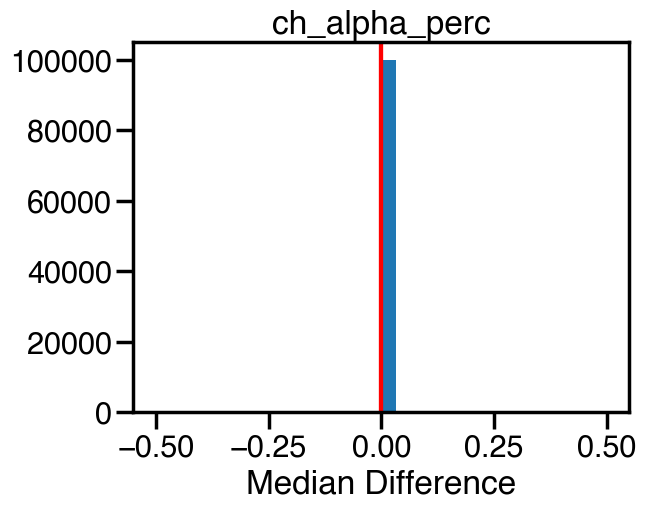

In [110]:
perm_test(alpha_osc_perc, feature='ch_alpha_perc')

## Merge Percentage Oscillation Dataframes

In [111]:
# merge percentage dfs
perc_df = pd.merge(theta_osc_perc, delta_osc_perc, how='outer', on=['patient', 'pre_post'])
perc_df = pd.merge(perc_df, alpha_osc_perc, how='outer', on=['patient', 'pre_post'])

In [112]:
# merge perc with main eeg feature df
exp_df_mean_wperc = pd.merge(exp_df_mean, perc_df, how='outer', on=['patient', 'pre_post'])

In [113]:
exp_df_mean_wperc.head()

,patient,pre_post,exponent,offset,delta_amp,delta_bp,theta_amp,theta_bp,theta_cf,delta_cf,alpha_amp,alpha_bp,alpha_bw,alpha_cf,theta_present,ch_theta_perc,delta_present,ch_delta_perc,alpha_present,ch_alpha_perc
0,3,post,1.396966,-10.728466,0.257114,-11.024550,0.657874,-11.177237,6.156632,2.809698,0.557219,-11.589878,2.764399,9.954654,55,0.916667,28,0.466667,59,0.983333
1,3,pre,0.475478,-11.985471,0.110521,-12.143266,0.283711,-12.224720,6.654823,1.471049,0.832821,-11.876280,1.582728,10.035655,38,0.633333,11,0.183333,60,1.000000
2,4,post,0.976076,-11.836341,0.095825,-12.158437,0.272331,-12.391280,4.576830,2.845098,0.999776,-12.115812,1.617806,9.229188,51,0.850000,3,0.050000,60,1.000000
3,4,pre,0.810115,-11.540574,0.210006,-11.752841,0.290177,-12.230327,5.305208,2.387229,1.476136,-11.343503,1.758423,10.042906,2,0.033333,1,0.016667,60,1.000000
4,10,post,1.256198,-11.092028,0.423947,-11.340693,0.931667,-11.093843,4.884811,3.541627,1.462693,-11.115364,2.498994,8.672413,59,0.983333,4,0.066667,60,1.000000


## Multiple Regression Spectral Analysis

What EEG features may be predictive of other EEG features? Specifically, what might be driving the bandpower differences pre vs. post?

### Using Treatment Difference

**Take difference of pre - post**

In [114]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_cf', 'ch_theta_perc', 'ch_delta_perc', 'ch_alpha_perc']


diff_df_mean_wperc = exp_df_mean_wperc.groupby(['patient'], as_index=False)[features].diff().dropna(0, how='all')
diff_df_mean_wperc['patient'] = exp_df_mean_wperc['patient']

diff_df_mean_wperc

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_11595/1529135655.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  diff_df_mean_wperc = exp_df_mean_wperc.groupby(['patient'], as_index=False)[features].diff().dropna(0, how='all')


,exponent,offset,delta_amp,delta_bp,theta_amp,theta_bp,theta_cf,delta_cf,alpha_amp,alpha_bp,alpha_cf,ch_theta_perc,ch_delta_perc,ch_alpha_perc,patient
1,-0.921488,-1.257006,-0.146593,-1.118715,-0.374163,-1.047483,0.498191,-1.338649,0.275602,-0.286402,0.081001,-0.283333,-0.283333,0.016667,3
3,-0.165961,0.295766,0.114182,0.405595,0.017846,0.160953,0.728377,-0.457869,0.476360,0.772309,0.813718,-0.816667,-0.033333,0.000000,4
5,-0.353966,-0.580045,-0.340982,-0.642551,-0.702216,-1.067190,0.864904,-0.106807,-0.338883,-0.726749,1.695905,-0.283333,0.116667,0.000000,10
7,-0.081453,-0.172336,0.014822,-0.164490,-0.046211,-0.212238,-0.257135,-0.143952,0.100156,-0.051523,0.028742,-0.166667,-0.016667,0.000000,13
9,-0.495305,-0.712337,NaN,-0.799572,-0.631210,-1.106876,0.828217,NaN,0.124481,-0.211126,1.022784,-0.316667,-0.133333,0.000000,16
11,-0.451485,-0.656820,NaN,-0.634137,NaN,-0.899623,NaN,NaN,-0.351969,-0.668322,0.645287,-0.466667,-0.050000,0.133333,18
13,-0.056655,-0.437258,-0.782657,-0.471741,-0.183102,-0.507658,-0.479381,0.795695,0.767590,0.051426,1.255797,-0.044444,0.133333,0.022222,19
15,-0.655069,-1.451715,0.296190,-1.382125,-0.409081,-1.560811,0.733550,-1.586368,-0.028930,-1.114945,1.123631,-0.644068,-0.338983,0.322034,25
17,-0.431639,-1.109275,-0.884084,-1.454383,-0.686753,-1.644640,-1.199895,-0.736019,-0.462283,-1.134528,1.133567,0.416667,-0.100000,0.100000,29
19,-0.760363,-1.013398,-0.213470,-1.018908,-0.374227,-0.846204,0.692400,0.536558,0.738249,0.159967,0.572588,-0.166667,-0.383333,0.000000,31


In [115]:
# multiple linear regression to see where changes in delta & theta come from
model = ols('delta_bp ~ exponent + delta_amp + ch_delta_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               delta_bp   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     7.324
Date:                Fri, 07 Jul 2023   Prob (F-statistic):             0.0111
Time:                        14:22:28   Log-Likelihood:                -2.5258
No. Observations:                  12   AIC:                             13.05
Df Residuals:                       8   BIC:                             14.99
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0664      0.236      0.282

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [116]:
# multiple linear regression to see where changes in delta & theta come from
model = ols('delta_bp ~ exponent + ch_delta_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               delta_bp   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     12.51
Date:                Fri, 07 Jul 2023   Prob (F-statistic):           0.000342
Time:                        14:22:28   Log-Likelihood:                -6.6324
No. Observations:                  22   AIC:                             19.26
Df Residuals:                      19   BIC:                             22.54
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.1766      0.179     -0.984

In [117]:
model = ols('theta_bp ~ exponent + theta_amp + ch_theta_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               theta_bp   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     18.92
Date:                Fri, 07 Jul 2023   Prob (F-statistic):           1.64e-05
Time:                        14:22:28   Log-Likelihood:                0.14873
No. Observations:                  20   AIC:                             7.703
Df Residuals:                      16   BIC:                             11.69
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.1874      0.138     -1.363

In [118]:
model.pvalues

Intercept        0.191803
exponent         0.060695
theta_amp        0.000018
ch_theta_perc    0.957088
dtype: float64

In [119]:
model = ols('alpha_bp ~ exponent + alpha_amp + ch_alpha_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               alpha_bp   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     7.892
Date:                Fri, 07 Jul 2023   Prob (F-statistic):            0.00144
Time:                        14:22:28   Log-Likelihood:                -4.2396
No. Observations:                  22   AIC:                             16.48
Df Residuals:                      18   BIC:                             20.84
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.2007      0.154     -1.305

In [120]:
model.pvalues

Intercept        0.208288
exponent         0.367662
alpha_amp        0.001224
ch_alpha_perc    0.075982
dtype: float64

# Standardized Beta Coefficients

In [126]:
features = ['exponent', 'delta_bp', 'delta_amp', 'ch_delta_perc']

# standardizing dataframe
df_z = diff_df_mean_wperc[features].dropna().apply(zscore)

# multiple linear regression to see where changes in delta & theta come from
model = ols('delta_bp ~ exponent + delta_amp + ch_delta_perc', df_z).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               delta_bp   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     7.324
Date:                Fri, 07 Jul 2023   Prob (F-statistic):             0.0111
Time:                        15:25:57   Log-Likelihood:                -9.1025
No. Observations:                  12   AIC:                             26.21
Df Residuals:                       8   BIC:                             28.14
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -8.327e-17      0.183  -4.56e-16

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [127]:
features = ['exponent', 'theta_bp', 'theta_amp', 'ch_theta_perc']

# standardizing dataframe
df_z = diff_df_mean_wperc[features].dropna().apply(zscore)

# multiple linear regression to see where changes in delta & theta come from
model = ols('theta_bp ~ exponent + theta_amp + ch_theta_perc', df_z).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               theta_bp   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     18.92
Date:                Fri, 07 Jul 2023   Prob (F-statistic):           1.64e-05
Time:                        15:26:20   Log-Likelihood:                -13.233
No. Observations:                  20   AIC:                             34.47
Df Residuals:                      16   BIC:                             38.45
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.857e-17      0.117   4.14e-16

In [128]:
features = ['exponent', 'alpha_bp', 'alpha_amp', 'ch_alpha_perc']

# standardizing dataframe
df_z = diff_df_mean_wperc[features].dropna().apply(zscore)

# multiple linear regression to see where changes in delta & theta come from
model = ols('alpha_bp ~ exponent + alpha_amp + ch_alpha_perc', df_z).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               alpha_bp   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     7.892
Date:                Fri, 07 Jul 2023   Prob (F-statistic):            0.00144
Time:                        15:26:48   Log-Likelihood:                -21.981
No. Observations:                  22   AIC:                             51.96
Df Residuals:                      18   BIC:                             56.33
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -6.939e-18      0.155  -4.48e-17